# Data import and visualization in scCODA

When performing compositional data analysis with scCODA, data can come from various sources.
Also, it is often helpful to gain some insight on the data via exploratory plotting before running the scCODA model.
In this tutorial notebook, we will

- convert data from various sources for use with scCODA via `sccoda.util.cell_composition_data`
- visualize the data with `sccoda.util.data_visualization`

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import warnings

from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

warnings.filterwarnings("ignore")


## Data import

scCODA uses the [anndata](https://github.com/theislab/anndata) format to handle cell count datasets and covariates in one object.
Here, `adata.X` contains the cell counts as a numpy array with the dimensions $sample \times celltype$, while `adata.obs` stores the covariate information for each sample as a pandas DataFrame.
`adata.var` can contain additional information on the cell types.

Besides manually creating the data object, `sccoda.util.cell_composition_data` gives methods to import data directly from a pandas DataFrame
or from gene-based anndata objects like in [scanpy](https://github.com/theislab/scanpy).

### Import from pandas

To import data from a pandas DataFrame (with each row representing a sample), it is sufficient to specify the names of the metadata (covariate columns).
As an example, we will use a dataset produced by [*Haber et al. [2017]*](https://www.nature.com/articles/nature24489),
describing pathogen infection in the small intestinal epithelium of the mouse.

In [2]:
# Read data into pandas from csv

cell_counts = scd.haber()

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft  
0  125       191    18  
1   11        40     5  
2  155       365    33  
3  130  

In [3]:
data_mouse = dat.from_pandas(cell_counts, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_mouse.obs["Condition"] = data_mouse.obs["Mouse"].str.replace(r"_[0-9]", "")
print(data_mouse.X)
print(data_mouse.obs)

[[ 36.  59. 136.  36. 239. 125. 191.  18.]
 [  5.  46.  23.  20.  50.  11.  40.   5.]
 [ 45.  98. 188. 124. 250. 155. 365.  33.]
 [ 26. 221. 198.  36. 131. 130. 196.   4.]
 [ 42.  71. 203. 147. 271. 109. 180. 146.]
 [ 40.  57. 383. 170. 321. 244. 256.  71.]
 [ 52.  75. 347.  66. 323. 263. 313.  51.]
 [ 65. 126. 115.  33.  65.  39. 129.  59.]
 [ 37. 332. 113.  59.  90.  47. 132.  10.]
 [ 32. 373. 116.  67. 117.  65. 168.  12.]]
            Mouse     Condition
0       Control_1       Control
1       Control_2       Control
2       Control_3       Control
3       Control_4       Control
4  H.poly.Day10_1  H.poly.Day10
5  H.poly.Day10_2  H.poly.Day10
6   H.poly.Day3_1   H.poly.Day3
7   H.poly.Day3_2   H.poly.Day3
8          Salm_1          Salm
9          Salm_2          Salm


### Import from scanpy

Cell type assignments are usually gained by clustering methods such as Louvain clustering.
The [scanpy](https://github.com/theislab/scanpy) platform provides a way of performing a variety of such assignment methods.
Even though scanpy also uses the anndata format, it does so on a level of $cell \times gene$.
To allow for quick transformation into scCODA's data format, some converter functions are available.

We will explore them on the [Preprocessing and clustering 3k PBMCs tutorial dataset of scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).
Since scCODA requires a distinction into samples, we will copy the dataset three times and add a new column `sample` to `adata.obs`.
Also, we need some covariate metadata, which we also simulate for this tutorial.

In [4]:
# read data
adata = ad.read_h5ad("../data/10x_pbmc68k_reduced.h5ad")
print(adata)


AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [5]:
# make three copys
adata_1 = adata.copy()
adata_1.obs["sample"] = 1

adata_2 = adata.copy()
adata_2.obs["sample"] = 2

adata_3 = adata.copy()
adata_3.obs["sample"] = 3

# join them together again
adata_all = ad.concat([adata_1, adata_2, adata_3])
print(adata_all)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 2100 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain', 'sample'
    obsm: 'X_pca', 'X_umap'


In [6]:
# make covariate DataFrame

cov_df = pd.DataFrame({"Cond": ["A", "B", "A"]}, index=[1,2,3])
print(cov_df)

  Cond
1    A
2    B
3    A


If we have one anndata object that contains the gene expression data for all samples, we can use `dat.from_scanpy`.
We just need to specify the columns in `adata.obs` that contain the sample information and the clustering results, as well as the covariate data frame.

In [7]:
data_scanpy_1 = dat.from_scanpy(
    adata_all,
    cell_type_identifier="louvain",
    sample_identifier="sample",
    covariate_df=cov_df
)
print(data_scanpy_1)

AnnData object with n_obs × n_vars = 3 × 11
    obs: 'Cond'
    var: 'n_cells'


If there is one anndata object per sample, we can use `dat.from_scanpy_list` in the same way.
Obviously, we do not need to specify a sample column now.

In [8]:
data_scanpy_2 = dat.from_scanpy_list(
    [adata_1, adata_2, adata_3],
    cell_type_identifier="louvain",
    covariate_df=cov_df
)
print(data_scanpy_2)

AnnData object with n_obs × n_vars = 3 × 11
    obs: 'Cond'
    var: 'n_cells'


## Compositional data visualization

Analyzing compositional data is not straightforward. scCODA provides some ways of visualizing the properties of a compositional dataset before analysis.
We will showcase these functions on the data on pathogen infection of mice from [*Haber et al. [2017]*](https://www.nature.com/articles/nature24489).

### Stacked barplot

The most common representation of cell count data in genomic research are stacked barplots.
In scCODA, these can be produced easily via `viz.stacked_barplot`.
The function can either plot one stacked bar for each level of a covariate, or one stacked bar for each sample.

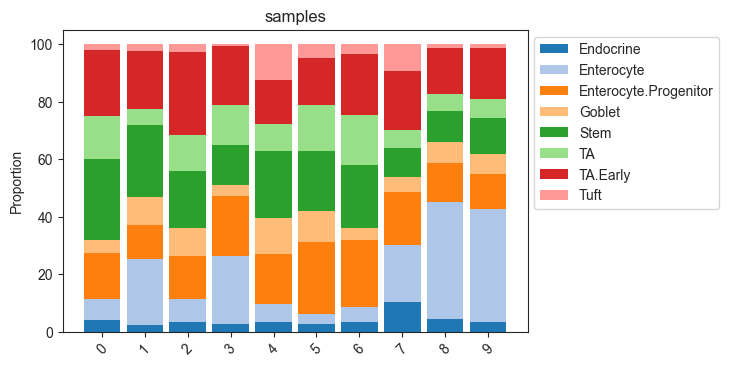

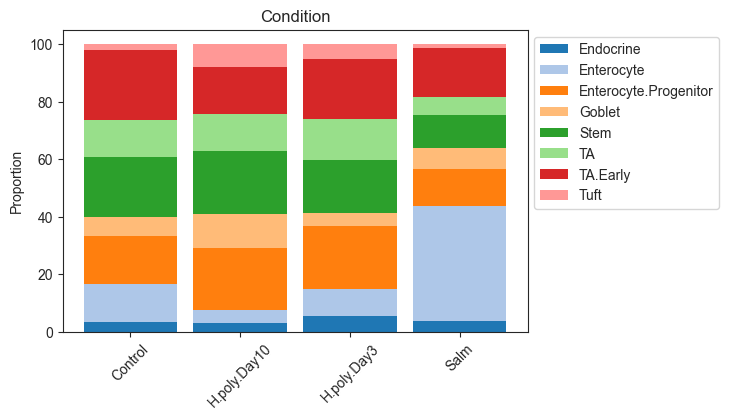

In [9]:
# Stacked barplot for each sample
viz.stacked_barplot(data_mouse, feature_name="samples")
plt.show()

# Stacked barplot for the levels of "Condition"
viz.stacked_barplot(data_mouse, feature_name="Condition")
plt.show()

### Grouped boxplots

While stached barplots are a nice and compact way of representing compositional data, they omit crucial information about the data variance.
Also, comparing the abundance of cell types that are not on the top or bottom of the bars can be hard.

To combat this, scCODA also provides a visualization via boxplots crouped by cell type and condition via `viz.boxplots`.
The function provides a lot of customization options, like log-scale plotting, representation as a faceted plot, or the addition of dots for each sample.

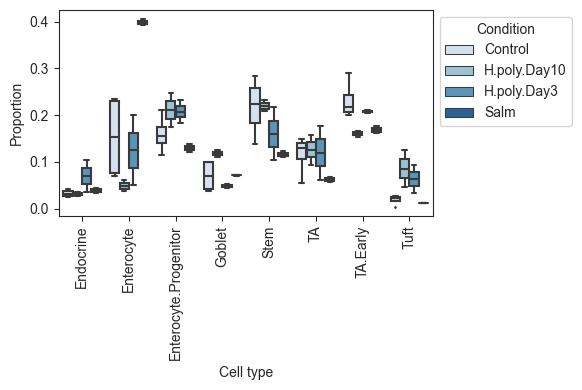

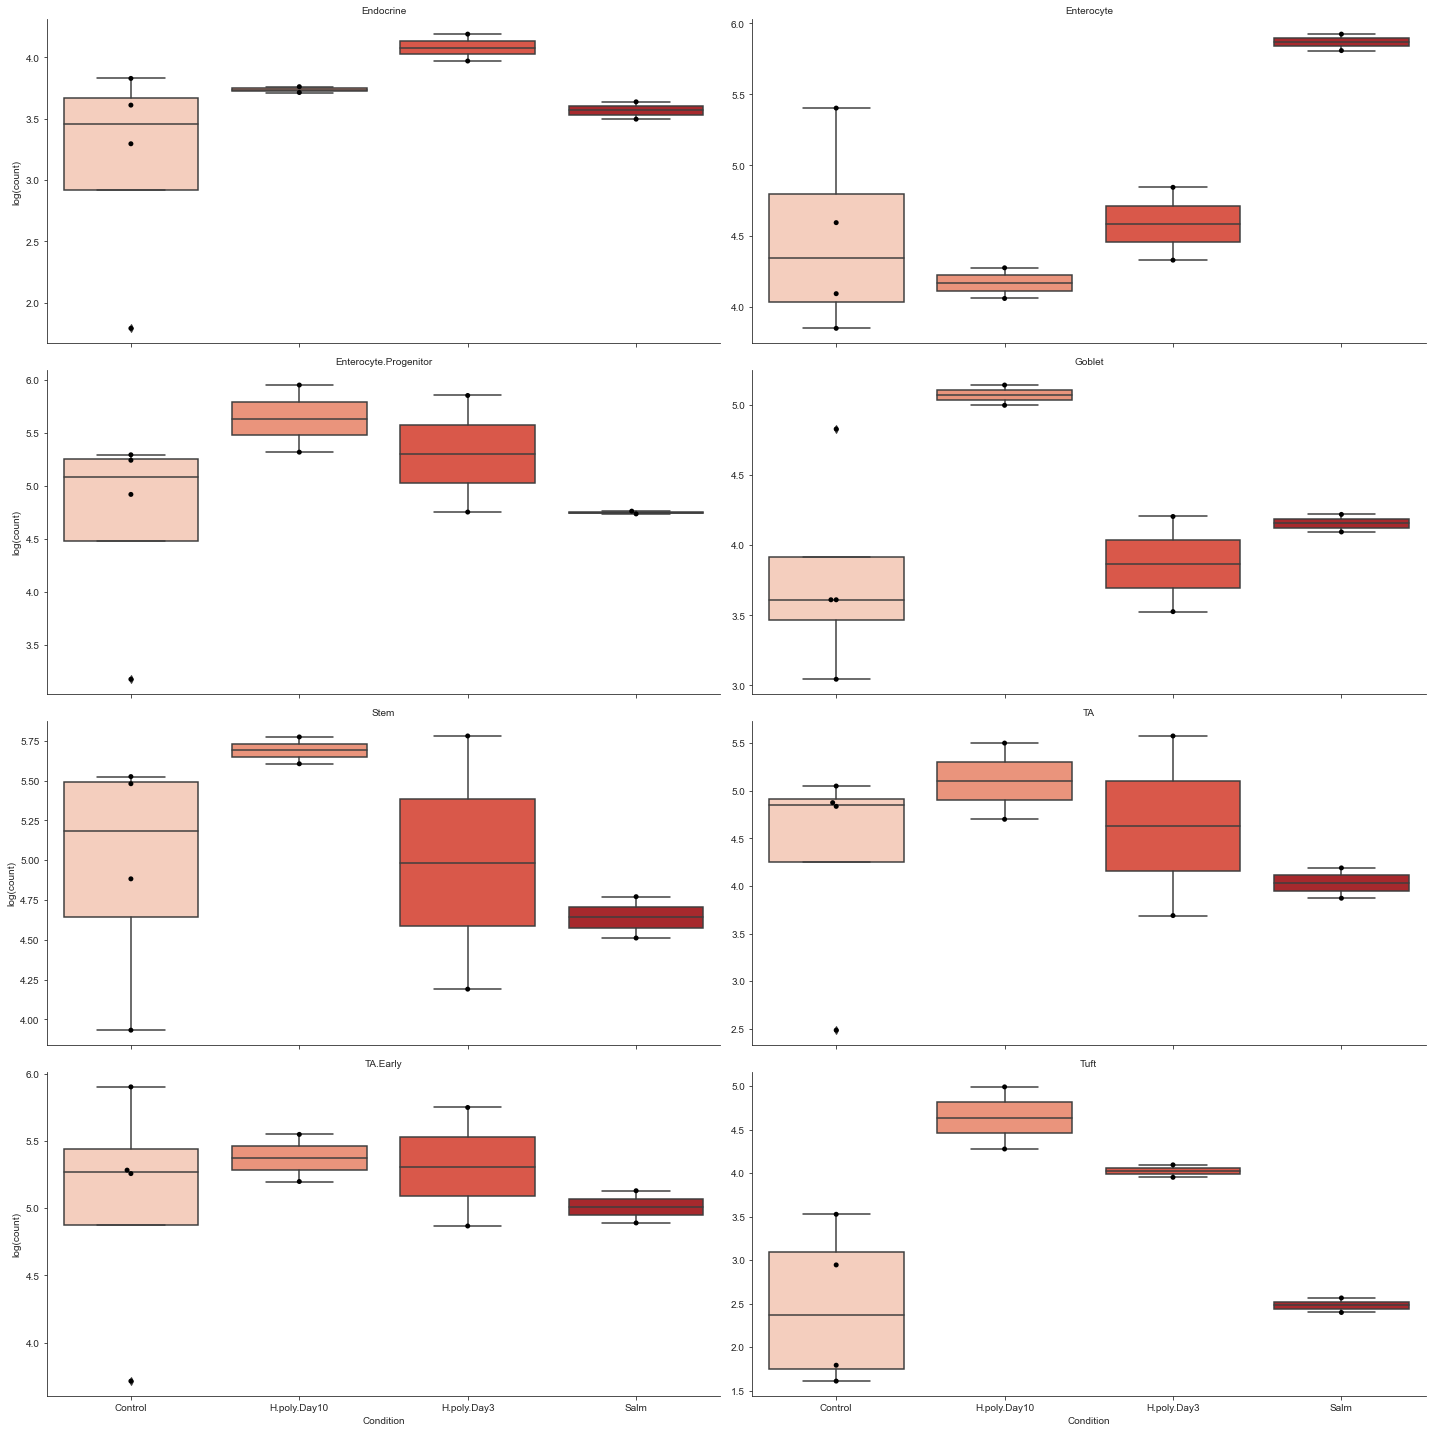

In [10]:
# Grouped boxplots. No facets, relative abundance, no dots.
viz.boxplots(
    data_mouse,
    feature_name="Condition",
    plot_facets=False,
    y_scale="relative",
    add_dots=False,
)
plt.show()

# Grouped boxplots. Facets, log scale, added dots and custom color palette.
viz.boxplots(
    data_mouse,
    feature_name="Condition",
    plot_facets=True,
    y_scale="log",
    add_dots=True,
    cmap="Reds",
)
plt.show()

### Finding a reference cell type
The scCODA model requires a cell type to be set as the reference category. However, choosing this cell type is often difficult.
A good first choice is a referenece cell type that closely preserves the changes in relative abundance during the compositional analysis.

For this, it is important that the reference cell type is not rare, to avoid large relative changes being caused by small absolute changes.
Also, the relative abundance of the reference should vary as little as possible across all samples.

The visualization `viz.rel_abundance_dispersion_plot` shows the presence (share of non-zero samples) over all samples for each cell type
versus its dispersion in relative abundance. Cell types that have a higher presence than a certain threshold (default 0.9) are suitable candidates for the reference and thus colored.

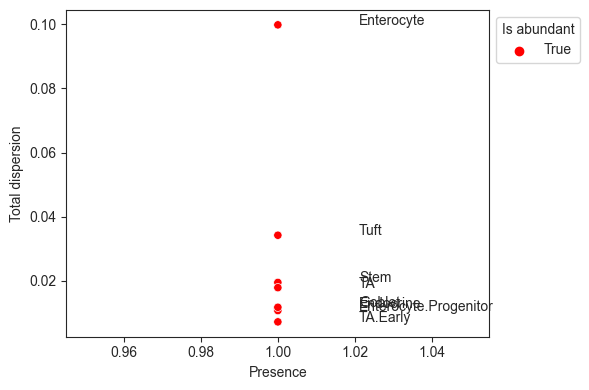

In [11]:
viz.rel_abundance_dispersion_plot(
    data=data_mouse,
    abundant_threshold=0.9
)
plt.show()